### Imports

In [2]:
import pandas as pd
import numpy as np
import scipy
import glob
from sklearn import cluster
from scipy.misc import imread
import skimage.measure as sm
import cv2
# import progressbar
import multiprocessing
from tqdm import *
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (20, 12)
import seaborn as sns
new_style = {'grid': False}
plt.rc('axes', **new_style)

### Help functions



In [4]:
# Function to show 4 images
def show_four(imgs, title):
    #select_imgs = [np.random.choice(imgs) for _ in range(4)]
    select_imgs = [imgs[np.random.choice(len(imgs))] for _ in range(4)]
    _, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(20, 3))
    plt.suptitle(title, size=20)
    for i, img in enumerate(select_imgs):
        ax[i].imshow(img)

# Function to show 8 images
def show_eight(imgs, title):
    select_imgs = [imgs[np.random.choice(len(imgs))] for _ in range(8)]
    _, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(20, 6))
    plt.suptitle(title, size=20)
    for i, img in enumerate(select_imgs):
        ax[i // 4, i % 4].imshow(img)
        
# Function for computing distance between images
def compare(args):
    img, img2 = args
    img = (img - img.mean()) / img.std()
    img2 = (img2 - img2.mean()) / img2.std()
    return np.mean(np.abs(img - img2))

### Input data

In [3]:
# select = 500 # Only load 500 images for speed
# # Data loading
# train_files = sorted(glob.glob('../../../Data/train/*/*.jpg'), key=lambda x: random.random())[:select]
# train = np.array([imread(img) for img in train_files])
# print('Length of train {}'.format(len(train)))

yellow = np.asarray(Image.open('../../../Data/mappie/img_00358.jpg'))
normal = np.asarray(Image.open('../../../Data/mappie/img_00950.jpg'))

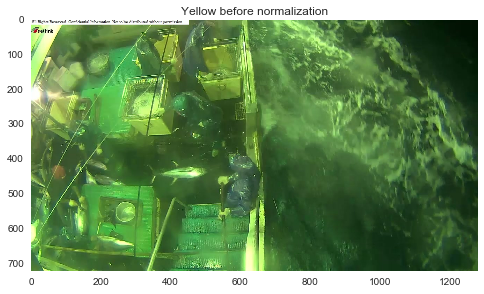

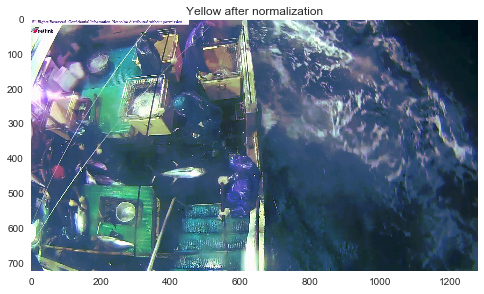

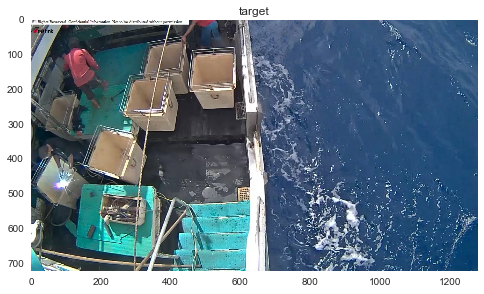

In [4]:
# function to do histogram matching
def get_histogram_matching_lut(h_input, h_template):
    ''' h_input: histogram to transfrom, h_template: reference'''
    if len(h_input) != len(h_template):
        print 'histograms length mismatch!'
        return False
    
    # Create cumulative sum histograms
    H_input = np.cumsum(h_input)
    H_template = np.cumsum(h_template)

    # Create empty LUT and fill (linear time)
    LUT = []
    for i in range(0, len(H_template)):
        for j in range(len(LUT), len(H_input)):
            
            # As long as the input value is not at the template value, match their index with the template index
            if (H_template[i] >= H_input[j]):
                LUT += [i]
            else:
                # Assure minimal distance is the criterium
                #if ( abs(H_template[i] - H_input[j]) < abs(H_template[i+1] - H_input[j])):
                    #LUT += [i]
                break
    
    LUT = np.asarray(LUT) # Turns list into array to match future code
    
    return LUT,H_input,H_template

def stain_normalization(input_img, target_img, n_bins=100):
    """ Stain normalization based on histogram matching. """
    input_img = input_img/255.0
    target_img = target_img/255.0

    normalized_img = np.zeros_like(input_img)
    for i in [0, 1, 2]:
        hist_input = np.histogram(input_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))
        hist_target = np.histogram(target_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))
        LUT, _, _ = get_histogram_matching_lut(hist_input[0], hist_target[0])
    
        stain_lut = LUT[(input_img[:, :, i] * (n_bins-1)).astype(int)].astype(float) / float(n_bins)
        normalized_img[:, :, i] = stain_lut
    
    
    return normalized_img

normalized = stain_normalization(yellow, normal)
plt.imshow(yellow); plt.title('Yellow before normalization')
plt.show()
plt.imshow(normalized); plt.title('Yellow after normalization')
plt.show()
plt.imshow(normal); plt.title('target')
plt.show()

### Scale image

In [6]:
# Resize the images to speed it up.
train = [cv2.resize(img, (224, 224), cv2.INTER_LINEAR) for img in train]

# train = [scipy.misc.imresize(img, (224,224)) for image in train]

### Compute distances

In [8]:
# Create the distance matrix in a multithreaded fashion
#pool = multiprocessing.Pool(8)
#bar = progressbar.ProgressBar(max=len(train))
distances = np.zeros((len(train), len(train)))
for i, img in enumerate(tqdm(train)): #enumerate(bar(train)):
    all_imgs = [(img, f) for f in train]
    dists = [compare(x) for x in all_imgs]
    distances[i, :] = dists

  3%|██                                                                               | 13/500 [00:45<28:57,  3.57s/it]


KeyboardInterrupt: 

### Clustering

In [ ]:
cls = cluster.DBSCAN(metric='precomputed', min_samples=5, eps=0.6)
y = cls.fit_predict(distances)

### Show images

In [ ]:
for uniq in pd.Series(y).value_counts().index:
    if uniq != -1:
        size = len(np.array(train)[y == uniq])
        if size > 10:
            show_eight(np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show()
        else:
            show_four(np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show()            